In [49]:
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

import torch
import torch.nn as nn
from torch import fx
from torch.nn import functional as F

from tvm import te

In [50]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.weight = nn.Parameter(torch.randn(128, 128))

    def forward(self, x):
        x = torch.matmul(x, self.weight)
        x = torch.relu(x)
        return x

In [51]:
model = MyModel()
fx_module = fx.symbolic_trace(model)
type(fx_module)

fx_module.graph.print_tabular()


opcode         name    target                                                     args         kwargs
-------------  ------  ---------------------------------------------------------  -----------  --------
placeholder    x       x                                                          ()           {}
get_attr       weight  weight                                                     ()           {}
call_function  matmul  <built-in method matmul of type object at 0x7f9e79f97760>  (x, weight)  {}
call_function  relu    <built-in method relu of type object at 0x7f9e79f97760>    (matmul,)    {}
output         output  output                                                     (relu,)      {}


大多数机器学习框架都带有计算图抽象，其中每个节点对应一个操作，边对应它们之间的依赖关系。 我们将采用 PyTorch 模型，获取 PyTorch 原生格式的计算图，并将其转换为 IRModule。

让我们定义整体的翻译逻辑。 主要流程如下：

1. 创建一个 node_map，将 fx.Node 映射到相应的 relax.Var，该 relax.Var 代表 IRModule 中的已翻译节点。

2. 以拓扑顺序迭代 FX 图中的节点。

3. 给定映射输入，获取节点的映射输出。

In [52]:
def map_param(param: nn.Parameter):
    return relax.const(param.data.cpu().numpy(), relax.TensorStructInfo(param.data.shape, "float32"))

def fetch_attr(fx_mod, target: str):
    """Helper function to fetch an attr"""
    target_atoms = target.split('.')
    attr_itr     = fx_mod
    for i, atom in enumerate(target_atoms):
        if not hasattr(attr_itr, atom):
            raise RuntimeError(f"Node referenced nonexistant target {'.'.join(target_atoms[:i])}")
        attr_itr = getattr(attr_itr, atom)
    return attr_itr

def from_fx(fx_mod, input_shapes, call_function_map, call_module_map):
    
    input_index   = 0
    node_map      = {}
    named_modules = dict(fx_mod.named_modules())
    
    print("named_modules = ", named_modules)

    bb = relax.BlockBuilder()

    fn_inputs = []
    fn_output = None
    with bb.function("main"):
        with bb.dataflow():
            for node in fx_mod.graph.nodes:    # 拓扑顺序迭代 FX 图中的节点。
                print("node = ", node)
                if node.op == "placeholder":
                    # create input placeholder
                    shape = input_shapes[input_index]
                    input_index += 1
                    input_var = relax.Var(
                        node.target, relax.TensorStructInfo(shape, "float32")
                    )
                    fn_inputs.append(input_var)
                    node_map[node] = input_var
                elif node.op == "get_attr":
                    node_map[node] = map_param(fetch_attr(fx_mod, node.target))
                elif node.op == "call_function": ## pure function
                    node_map[node] = call_function_map[node.target](bb, node_map, node)
                elif node.op == "call_module":   ## 'function' with fixed parameters
                    named_module = named_modules[node.target]
                    print("type(named_module) = ", type(named_module))
                    print("node.target        = ", node.target)
                    node_map[node] = call_module_map[type(named_module)](bb, node_map, node, named_module)
                elif node.op == "output":
                    output = node_map[node.args[0]]
                    assert fn_output is None
                    fn_output = bb.emit_output(output)
        # output and finalize the function
        bb.emit_func_output(output, fn_inputs)
    return bb.get()

# 定义函数映射 

def te_matmul(A: te.Tensor, B: te.Tensor) -> te.Tensor:
    assert A.shape[1] == B.shape[0]
    n = A.shape[0]
    m = B.shape[1]
    k = te.reduce_axis((0, A.shape[1]), name="k")
    return te.compute((n, m), lambda i, j: te.sum(A[i, k] * B[k, j], axis=k), name="matmul")

def te_relu(A: te.Tensor) -> te.Tensor:
    return te.compute(A.shape, lambda *i: te.max(A(*i), 0), name="relu")

def map_matmul(bb, node_map, node: fx.Node):
    A = node_map[node.args[0]]
    B = node_map[node.args[1]]
    return bb.emit_te(te_matmul, A, B)

def map_relu(bb, node_map, node: fx.Node):
    A = node_map[node.args[0]]
    return bb.emit_te(te_relu, A)

MyModule = from_fx(
    fx_module,
    input_shapes = [(1, 128)],
    call_function_map = {
      torch.matmul: map_matmul,
      torch.relu: map_relu,
    },
    call_module_map={},
)

MyModule.show()

named_modules =  {'': MyModel()}
node =  x
node =  weight
node =  matmul
node =  relu
node =  output


# FASHION MNIST

In [53]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

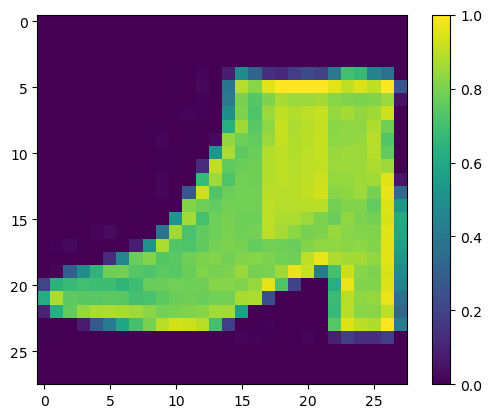

Class: Ankle boot


In [54]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [55]:
# Hide outputs
!wget -nc https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

File ‘fasionmnist_mlp_params.pkl’ already there; not retrieving.



In [56]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear0 = nn.Linear(784, 128, bias=True)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(128, 10, bias=True)

    def forward(self, x):
        x = self.linear0(x)
        x = self.relu(x)
        x = self.linear1(x)
        return x

import pickle as pkl

mlp_model = MLP()

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
mlp_model.linear0.weight.data = torch.from_numpy(mlp_params["w0"])
mlp_model.linear0.bias.data   = torch.from_numpy(mlp_params["b0"])
mlp_model.linear1.weight.data = torch.from_numpy(mlp_params["w1"])
mlp_model.linear1.bias.data   = torch.from_numpy(mlp_params["b1"])

torch_res = mlp_model(torch.from_numpy(img.reshape(1, 784)))

pred_kind = np.argmax(torch_res.detach().numpy(), axis=1)
print("Torch Prediction:", class_names[pred_kind[0]])

Torch Prediction: Ankle boot


In [57]:
from tvm import topi


def map_nn_linear(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]
    w = map_param(nn_mod.weight)
    if nn_mod.bias is not None:
        b = map_param(nn_mod.bias)
    y = bb.emit_te(topi.nn.dense, x, w)
    return bb.emit_te(topi.add, y, b)

def map_nn_relu(bb, node_map, node, nn_mod):
    return map_relu(bb, node_map, node)


MLPModule = from_fx(
    fx.symbolic_trace(mlp_model),
    input_shapes = [(1, 784)],
    call_function_map={
    },  # 注意这里无 function ! 
    call_module_map={
        torch.nn.Linear: map_nn_linear,
        torch.nn.ReLU: map_nn_relu,
    },  # 所有的都是 module ! 
)

MLPModule.show()

named_modules =  {'': MLP(
  (linear0): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (linear1): Linear(in_features=128, out_features=10, bias=True)
), 'linear0': Linear(in_features=784, out_features=128, bias=True), 'relu': ReLU(), 'linear1': Linear(in_features=128, out_features=10, bias=True)}
node =  x
node =  linear0
type(named_module) =  <class 'torch.nn.modules.linear.Linear'>
node.target        =  linear0
node =  relu
type(named_module) =  <class 'torch.nn.modules.activation.ReLU'>
node.target        =  relu
node =  linear1
type(named_module) =  <class 'torch.nn.modules.linear.Linear'>
node.target        =  linear1
node =  output


## 备注：翻译成高层算子

In [58]:
def map_nn_relu_op(bb, node_map, node, nn_mod):
    A = node_map[node.args[0]]
    return bb.emit(relax.op.nn.relu(A))

def map_nn_linear_op(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]
    w = map_param(nn_mod.weight)
    b = map_param(nn_mod.bias)
    return bb.emit(relax.op.linear(x, w, b))

MLPModuleHighLevel = from_fx(
    fx.symbolic_trace(mlp_model),
    input_shapes = [(1, 784)],
    call_function_map={
    },
    call_module_map={
        torch.nn.Linear: map_nn_linear_op,
        torch.nn.ReLU: map_nn_relu_op,
    },
)

MLPModuleHighLevel.show()

named_modules =  {'': MLP(
  (linear0): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (linear1): Linear(in_features=128, out_features=10, bias=True)
), 'linear0': Linear(in_features=784, out_features=128, bias=True), 'relu': ReLU(), 'linear1': Linear(in_features=128, out_features=10, bias=True)}
node =  x
node =  linear0
type(named_module) =  <class 'torch.nn.modules.linear.Linear'>
node.target        =  linear0
node =  relu
type(named_module) =  <class 'torch.nn.modules.activation.ReLU'>
node.target        =  relu
node =  linear1
type(named_module) =  <class 'torch.nn.modules.linear.Linear'>
node.target        =  linear1
node =  output
